In [1]:
from datasets import load_dataset

dataset_name = 'BLINK-Benchmark/BLINK'
data = load_dataset(dataset_name, 'Jigsaw')


c:\Users\samyv\miniconda3\envs\assignment_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


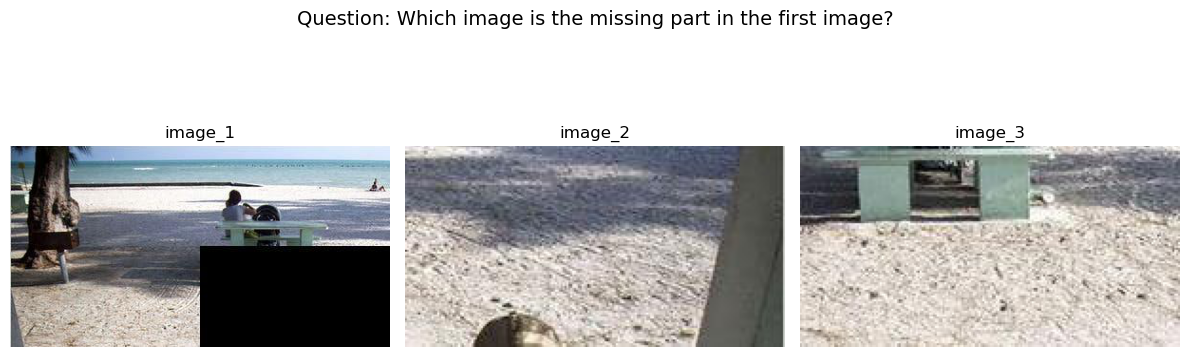

Prompt: Given the first image with the lower right corner missing, can you tell which one of the second image or the third image is the missing part? Imagine which image would be more appropriate to place in the missing spot. You can also carefully observe and compare the edges of the images.
Select from the following choices.

(A) the second image
(B) the third image

Choices:
  A. the second image
  B. the third image

Correct Answer: (B)


In [35]:
import matplotlib.pyplot as plt
data_val = data['val']

def show_question_with_images(data, index):
    example = data[index]
    image_keys = ['image_1', 'image_2', 'image_3', 'image_4']
    
    images = [(key, example[key]) for key in image_keys if example[key] is not None]
    
    # display images in a row
    fig, axes = plt.subplots(1, len(images), figsize=(4 * len(images), 4))
    if len(images) == 1:
        axes = [axes]  
    for ax, (label, img) in zip(axes, images):
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.suptitle(f"Question: {example['question']}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # show choices and correct answer
    print("Prompt:", example["prompt"])
    print("Choices:")
    for i, choice in enumerate(example['choices']):
        print(f"  {chr(65 + i)}. {choice}")
    print("\nCorrect Answer:", example['answer'])

    if example.get('explanation'):
        print("\nExplanation:", example['explanation'])

show_question_with_images(data_val,62)   


In [3]:
import os 
import numpy as np
# Create output directory
output_dir = "image_1_folder"
os.makedirs(output_dir, exist_ok=True)

# Loop and save each image_1
for i, example in enumerate(data_val):
    img = example.get('image_1')
    if img is not None:
        # Convert to PIL Image if it's a NumPy array
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        # Save image
        img_path = os.path.join(output_dir, f"image_1_{i}.png")
        img.save(img_path)

print(f"Saved {len(os.listdir(output_dir))} images to {output_dir}")

Saved 150 images to image_1_folder


### """Specialist""" model

There is no specialist model for this jigsaw task in particular. That explains the absence of this category in Table 2 of the paper.

My idea to still try to compare VLM performance is to use a specialist inpainting model that can reconstruct the missing region, and then compare the result to each of the two candidates to see which fits better. The issue is that there is no real specialist model for that, in the sense that reconstructing a quarter of an image is still an incredibly hard task for current models.

I tried to use LaMa (https://github.com/advimman/lama?tab=readme-ov-file), which leverages fast Fourier convolutions with image-wide receptive field allowing to complete large missing areas.
Their method improved the state-of-the-art across a range of datasets when the paper was published in 2021.

I modified their Colab notebook (in their GitHub repository) to automatically take the bottom right of the images as the mask, and I ran the inference for around 100 images from the BLINK "Jigsaw" category.

Once I have the reconstructed images, I crop the bottom right part and compute the similarity with the 2 candidates from the dataset. The one with higher similarity is considered as the better fit by the "specialized" model.

In [4]:
# !pip install lpips

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\samyv\miniconda3\envs\assignment_pytorch\lib\site-packages\lpips\weights\v0.1\alex.pth
Index 12: Best Match = B, Real answer = (B) (LPIPS A: 0.4357, B: 0.4070)


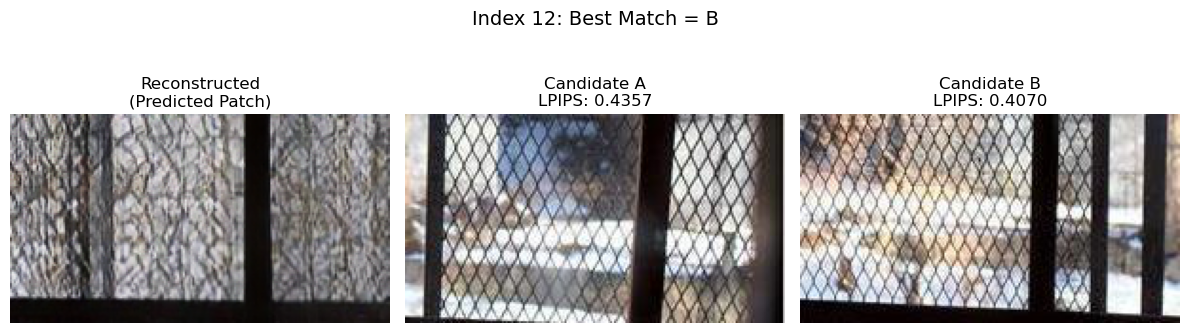

'B'

In [32]:
import os
from PIL import Image
import torch
import lpips
import numpy as np

#  LPIPS model : Learned Perceptual Image Patch Similarity
lpips_model = lpips.LPIPS(net='alex').cuda()

# Parameters
recon_dir = './image_1_completed/'
# patch_size = 64  # You can adjust based on image size

def crop_bottom_right(image):
    w, h = image.size
    return image.crop((w *0.5, h *0.5, w, h))

def load_image(path):
    if isinstance(path, Image.Image):
        return path.convert('RGB')  # already a PIL image
    return Image.open(path).convert('RGB') 

def to_tensor(image):
    img = np.array(image).astype(np.float32) / 255.0
    img = torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0).cuda()
    return img

def plot_patches(index, recon_patch, cand2_patch, cand3_patch, dist2, dist3, best):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(recon_patch)
    axs[0].set_title(f"Reconstructed\n(Predicted Patch)")
    axs[1].imshow(cand2_patch)
    axs[1].set_title(f"Candidate A\nLPIPS: {dist2:.4f}")
    axs[2].imshow(cand3_patch)
    axs[2].set_title(f"Candidate B\nLPIPS: {dist3:.4f}")

    for ax in axs:
        ax.axis('off')

    plt.suptitle(f"Index {index}: Best Match = {best}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
def compare_candidates(index, data_entry,plot = False):
    recon_path = os.path.join(recon_dir, f"image_1_{index}_mask.png")
    if not os.path.exists(recon_path):
        print(f"Reconstructed image not found for index {index}")
        return None

    recon_img = load_image(recon_path)
    candidate2 = load_image(data_entry['image_2'])
    candidate3 = load_image(data_entry['image_3'])

    # Crop bottom-right patches
    recon_patch = crop_bottom_right(recon_img)
    cand2_patch = candidate2#crop_bottom_right(candidate2)
    cand3_patch = candidate3#crop_bottom_right(candidate3)
    assert recon_patch.size == cand2_patch.size == cand3_patch.size, f"Size mismatch: {recon_patch.size}, {cand2_patch.size}, {cand3_patch.size}"
    # plot_patches(index, recon_patch, cand2_patch, cand3_patch, 0,0,None)#dist2, dist3, best)

    recon_tensor = to_tensor(recon_patch)
    cand2_tensor = to_tensor(cand2_patch)
    cand3_tensor = to_tensor(cand3_patch)

    # Compare using LPIPS
    dist2 = lpips_model(recon_tensor, cand2_tensor).item()
    dist3 = lpips_model(recon_tensor, cand3_tensor).item()

    # Decide best match
    best = 'B' if dist3 < dist2 else 'A'
    print(f"Index {index}: Best Match = {best}, Real answer = {data_entry['answer']} (LPIPS A: {dist2:.4f}, B: {dist3:.4f})")
    if plot : plot_patches(index, recon_patch, cand2_patch, cand3_patch, dist2, dist3, best)
    return best

ind = 12
compare_candidates(ind,data_val[ind],plot=True)

In [25]:
def evaluate_model(data):
    correct = 0
    total = 0

    for index, example in enumerate(data):
        # print(example)

        prediction = compare_candidates(index, example)
        if prediction is None:
            continue  # skip if reconstructed image not found

        ground_truth = example['answer'].strip("() ")  # Normalize e.g. "(B)" → "B"

        if prediction == ground_truth:
            correct += 1
        total += 1

    accuracy = correct / total if total > 0 else 0
    print(f"\nEvaluation Complete: {correct}/{total} correct, Accuracy: {accuracy:.2%}")
    return accuracy

accuracy = evaluate_model(data_val)


Index 0: Best Match = B, Real answer = (B) (LPIPS A: 0.6184, B: 0.5006)
Index 1: Best Match = B, Real answer = (B) (LPIPS A: 0.6100, B: 0.4523)
Index 2: Best Match = B, Real answer = (A) (LPIPS A: 0.5572, B: 0.5487)
Index 3: Best Match = A, Real answer = (A) (LPIPS A: 0.5381, B: 0.6008)
Index 4: Best Match = A, Real answer = (B) (LPIPS A: 0.4468, B: 0.4521)
Index 5: Best Match = A, Real answer = (A) (LPIPS A: 0.4503, B: 0.4636)
Index 6: Best Match = A, Real answer = (A) (LPIPS A: 0.4806, B: 0.6116)
Index 7: Best Match = A, Real answer = (A) (LPIPS A: 0.4654, B: 0.5661)
Index 8: Best Match = B, Real answer = (B) (LPIPS A: 0.5775, B: 0.5440)
Index 9: Best Match = A, Real answer = (A) (LPIPS A: 0.3592, B: 0.6094)
Index 10: Best Match = A, Real answer = (B) (LPIPS A: 0.5414, B: 0.5657)
Index 11: Best Match = A, Real answer = (A) (LPIPS A: 0.4613, B: 0.5123)
Index 12: Best Match = B, Real answer = (B) (LPIPS A: 0.4357, B: 0.4070)
Index 13: Best Match = B, Real answer = (A) (LPIPS A: 0.5778,